<div class="head0">
    <div class="head0__name">
        TMP file
    </div>
</div>

In [1]:
import torch
import tntorch as tn

In [2]:
t = tn.randn(128, 128, ranks_tt=10, requires_grad=True)
t

2D TT tensor:

 128 128
  |   |
 (0) (1)
 / \ / \
1   10  1

In [3]:
print(tn.mean(t))
print(tn.var(t))
print(tn.norm(t))
print(tn.norm(t+t))
print(tn.norm(2*t))

tensor(0.0433, grad_fn=<SqueezeBackward0>)
tensor(9.9505, grad_fn=<DivBackward0>)
tensor(403.8066, grad_fn=<SqrtBackward>)
tensor(807.6137, grad_fn=<SqrtBackward>)
tensor(807.6133, grad_fn=<SqrtBackward>)


In [4]:
print(t.torch().shape)

torch.Size([128, 128])


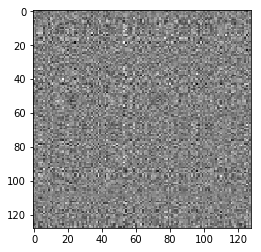

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(t.numpy(), cmap='gray')
plt.show()

iter: 0       | loss: 216.345139 | total time:    0.0027
iter: 500     | loss:  90.357666 | total time:    0.7181
iter: 1000    | loss:  18.213350 | total time:    1.3288
iter: 1374    | loss:   0.091215 | total time:    1.7977 <- converged (tol=0.0001)


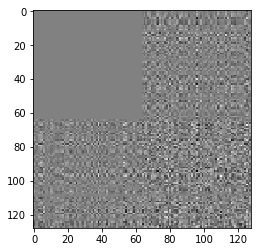

In [6]:
def loss(t):
    return tn.norm(t[:64, :64])

tn.optimize(t, loss)
plt.imshow(t.numpy(), cmap='gray')
plt.show()

In [2]:
import time
import numpy as np
import scipy.sparse as sp
from scipy.integrate import solve_ivp
from scipy.linalg import expm as expm
import matplotlib.pyplot as plt
import tt
from tt.cross.rectcross import cross as tt_cross
from fpcross import ij, Grid, Func, Solver, Model, Check

ij()

Start |  9:29AM MSK on Oct 18, 2019 | python 3.7.1    |
-------------------------------------------------------


In [2]:
import random
for i in range(5):
    random.randint(0, 9)

Signature: random.randint(a, b)
Docstring:
Return random integer in range [a, b], including both end points.
        
File:      /anaconda3/lib/python3.7/random.py
Type:      method


In [15]:
def integrate_cheb(A):

    if not isinstance(A, np.ndarray): A = np.array(A)
    if len(A.shape) == 1: A = A.reshape(-1, 1)

    n = np.arange(A.shape[0])[::2]
    n = np.repeat(n.reshape(-1, 1), A.shape[1], axis=1)

    return np.sum(A[::2, :] / (1. - n**2), axis=0)

In [16]:
def integrate_cheb(A):

    if not isinstance(A, np.ndarray): A = np.array(A)
    if len(A.shape) == 1: A = A.reshape(-1, 1)

    n = np.arange(A.shape[0])
    n[1::2] = 0.
    n = 2. / (1. - n**2)
    n = n.reshape(1, -1)
    v = n @ A
    v = v.reshape(-1)

    return v

In [17]:
def func_for_int(X, d, a=2.):
    r = np.exp(-np.sum(X*X, axis=0) / a) / (np.pi * a)**(d/2)
    return r.reshape(-1)

In [27]:
GR = Grid(n=[35, 35, 35], l=[-10., 10.])
FN = Func(GR).init(lambda X: func_for_int(X, 3))
FN.prep()
FN.calc()
v = FN.A.copy()

for k in range(FN.SG.d):
    v = v.reshape(FN.SG.n[k], -1)
    v = integrate_cheb(v)
    v*= (FN.SG.l[k, 1] - FN.SG.l[k, 0]) / 2.
v = v[0]

e = np.abs(1. - v)
print('Error : %-8.2e'%e)

Error : 5.99e-07


In [29]:
def integrate_cheb(A):

    if not isinstance(A, np.ndarray): A = np.array(A)
    if len(A.shape) == 1: A = A.reshape(-1, 1)

    n = np.arange(A.shape[0])
    n[1::2] = 0.
    n = 2. / (1. - n**2)
    n = n.reshape(1, -1)
    v = n @ A
    v = v.reshape(-1)

    return v

In [34]:
import tt

GR = Grid(n=[35, 35, 35], l=[-10., 10.])
FN = Func(GR, with_tt=True).init(lambda X: func_for_int(X, 3))
FN.prep()
FN.calc()

G = tt.tensor.to_list(FN.A)
Q = np.array([[1.]])

for k in range(FN.SG.d):
    G_sh = G[k].shape
    G[k] = np.swapaxes(G[k], 0, 1)
    G[k] = G[k].reshape(G_sh[1], -1)
    G[k] = integrate_cheb(G[k])
    G[k] = G[k].reshape(G_sh[0], G_sh[2])
    G[k]*= (FN.SG.l[k, 1] - FN.SG.l[k, 0]) / 2.

    Q = Q @ G[k]   

v = Q[0, 0]

e = np.abs(1. - v)
print('Error : %-8.2e'%e)

Error : 5.99e-07


In [22]:
d = 10
e = 1.E-14
A = tt.ones(2, d)
A = A + A
delt = e / np.sqrt(d - 1)

G = tt.tensor.to_list(A)

for k in range(d-1, 0, -1):
    print(k)
    Q, R = np.linalg.qr(G[k])
    G[k] = Q
    G[k-1] = np.einsum('riq,qj->rij', G[k-1], R)
print(G)

9


LinAlgError: 3-dimensional array given. Array must be two-dimensional

In [4]:
a = tt.ones(2, 10)
a = a + a
print(a.r)
a = a.round(1E-14)
print(a.r)

[1 2 2 2 2 2 2 2 2 2 1]
[1 1 1 1 1 1 1 1 1 1 1]


In [13]:
a = np.random.randn(2, 3)
q, r = np.linalg.qr(a)

print(a.shape)
print(q.shape)
print(r.shape)

(2, 3)
(2, 2)
(2, 3)


In [14]:
np.allclose(a, q @ r)

True

In [1]:
import numpy as np

def clenshaw_curtis_compute ( n ):
    if ( n == 1 ):

        x = np.zeros ( n )
        w = np.zeros ( n )

        w[0] = 2.0

    else:

        theta = np.zeros ( n )

        for i in range ( 0, n ):
            theta[i] = float ( n - 1 - i ) * np.pi / float ( n - 1 )

        x = np.cos ( theta )
        w = np.zeros ( n )

        for i in range ( 0, n ):
            w[i] = 1.0
            jhi = ( ( n - 1 ) // 2 )
            
            for j in range ( 0, jhi ):

                if ( 2 * ( j + 1 ) == ( n - 1 ) ):
                    b = 1.0
                else:
                    b = 2.0

                w[i] = w[i] - b * np.cos ( 2.0 * float ( j + 1 ) * theta[i] ) \
                / float ( 4 * j * ( j + 2 ) + 3 )

        w[0] = w[0] / float ( n - 1 )
        for i in range ( 1, n - 1 ):
            w[i] = 2.0 * w[i] / float ( n - 1 )
        w[n-1] = w[n-1] / float ( n - 1 )

    return x, w
  
n = 5
x, w = clenshaw_curtis_compute(n)

for i in range(n):
    print('%2d  %24.16g  %24.16g'%(i, x[i], w[i]))

 0                        -1       0.06666666666666668
 1       -0.7071067811865475        0.5333333333333334
 2     6.123233995736766e-17        0.7999999999999999
 3        0.7071067811865476        0.5333333333333333
 4                         1       0.06666666666666668


In [ ]:
def func(x):
    return x**2

def func_int(x):
    return x**3 / 3.

a, b = -1., 1.
r_calc = ClenshawCurtis(func, a, b, 1000)
r_real = func_int(b) - func_int(a)
e = np.abs((r_real - r_calc) / r_real)

print('Res. real : %-8.2e'%r_real)
print('Res. calc : %-8.2e'%r_calc)
print('Error     : %-8.2e'%e)

In [ ]:
from math import pi, cos

def ClenshawCurtis(function, a, b, N):
    return CC(function,N)

# Generate quadrature weights a2k = (2/N)[(f(1)+f(-1))/2 + f(0)*(-1**k) + 
# FROM n = 1 => (N/2)-1 SUM {f(cos[n*pi/N]) + f(-cos[n*pi/N])} cos(n*k*pi/(N/2)]
def a2k(function,k, N):
    sum = 0
    for n in range (1, (int(N)//2)-1):
        sum += (function(cos((n*pi)/N))+function(-cos((n*pi/N))))*(cos(n*k*pi/(N/2.)))
#        print("a2k sum:",sum)
    return (2/N)*((function(1.)+function(-1.))/2.+function(0)*(-1.**k)+sum) # COV for -1,0,1?

# CC = a0 + FROM k=1 => (N/2)-1 SUM 2*a(2k)/(1-(2k)**2) + aN/(1-N**2)
def CC(function,N):
    sum = 0
    for k in range (1, (int(N)//2)-1):
        sum += (2.*a2k(function,k, N)/(1.-((2.*k)**2.)))
#        print("CC sum:",sum)
#    print (a2k(function,0, N))
    return a2k(function,0, N)+sum+(a2k(function,N/2,N)/(1-(N**2)))


# Change of variable from [-1, 1] to [a, b] 
def COVorigin(o):
    #return (2*x)/(b-a)+(-b-a)/(b-a)
    return o*(b-a)/2.+(a+b)/2.
# Change of variable from [0, pi] to [-1, 1]
def COVtheta(t):
    #return (((pi/2)*COVorigin(x))+pi/2)
    return (((2./pi)*t)-1.)
# Change of variable from [0, pi] to [-1, 1] to [a, b] 
def COV(t):
    return COVorigin(COVtheta(t))

<div class="head1">
    <div class="head1__name">
        Rounding for cross
    </div>
</div>

In [34]:
def func(x):
    return 1. / (2. + np.sum(x, axis=1))
    
n = [4, 6, 8, 9]
r = [3, 9, 7, 1]
Z = tt.rand(n, d=len(n), r=[1] + r)

rmax = None
for n_, r_ in zip(n, Z.r[1:]):
    if r_ > n_:
        if rmax is None or rmax > n_:
            rmax = n_

if rmax is not None:
    print('Round to %d'%rmax)
    Z = Z.round(rmax=rmax)

Y = tt_cross(func, Z, eps=1.E-6, nswp=200, kickrank=1, rf=2, verbose=True)

print('Z :', Z)
print('Y :', Y)

Round to 6
swp: 0/199 er_rel = 1.5e+02 er_abs = 5.6e+02 erank = 7.6 fun_eval: 1334
swp: 1/199 er_rel = 2.2e-07 er_abs = 8.3e-07 erank = 9.3 fun_eval: 3330
Z : This is a 4-dimensional tensor 
r(0)=1, n(0)=4 
r(1)=3, n(1)=6 
r(2)=6, n(2)=8 
r(3)=6, n(3)=9 
r(4)=1 

Y : This is a 4-dimensional tensor 
r(0)=1, n(0)=4 
r(1)=5, n(1)=6 
r(2)=12, n(2)=8 
r(3)=9, n(3)=9 
r(4)=1 



<div class="head1">
    <div class="head1__name">
        Algorithm (1th order)
    </div>
    <div class="head1__note">
        This is a draft of the algorithm. which is used in solver module/class (Russian is used for simplicity).
    </div>
</div>

**Задача:** найти PDF $\rho$ в момент времени $t$ на Чебышевской сетке из уравнений
$$
    dx = f(x, t) \, dt + d\beta,
    \quad
    d\beta \, d\beta^{\top} = 2 I dt,
    \quad
    \frac{\partial \rho}{\partial t} = \Delta \rho - div \left[ f(x, t) \rho \right],
    \quad
    \rho(x, 0) = \rho_0(x).
$$

**Нужно** передать в крест (tt-cross) функцию (step), которая вычисляет значения $\rho_{k+1}$ в заданном (произвольном) наборе точек $X$ Чебышевской сетки. Это позволит проинтерполировать $\rho$ на $(k+1)$-ом шаге и перейти к следующему шагу, при этом предполагается, что интерполянт для $k$-ого шага уже известен.

> На нулевом шаге имеем $\rho_0(x)$, заданную как функцию от $x$ и можем построить интерполянт очевидным образом.

> Если не используем крест (работаем в полном numpy формате), то $X$ - это полный набор точек Чебышевской сетки (алгоритм при этом остается прежним).

> Алгоритм расписан для splitting схемы первого порядка, поэтому для решения ODE можем использовать метод Эйлера без потери точности.

**Работа функции step(X)**

> X - произвольный набор точек Чебышевской сетки (ndarray [dims, pois] of float)

**1** Найти прообразы $\widehat{X}$ (соответствуют предыдущему $k$-ому шагу) для заданного набора точек $X$ Чебышевской сетки, которые приводили бы траекторию детерминированного уравнения ($\beta = 0$) в точки $X$ на $(k+1)$-ом шаге, интегрируя назад уравнение
$$
    \frac{\partial \, x}{\partial \, t} = f(x, t),
    \quad
    x_{k+1} = X,
    \quad
    x_{k} = \widehat{X} = ?,
$$
используя формулу Эйлера
$$
    \widehat{X} = X - h \cdot f(X, t_{k+1}).
$$

**2** Используя известный интерполянт $E^{(\rho)}_k$ на $k$-ом шаге, вычислить в точках $\widehat{X}$ значения PDF $\widehat{\rho} = \tilde{E}^{(\rho)}_k(\widehat{X})$, где знак ~ в $\tilde{E}^{(\rho)}_k$ соответствует обнулению значений для точек, которые оказались вне пределов интерполяции.

**3** Решить PDE с однородными граничными условиями Дирихле для $(k+1)$-ого шага
$$
    \frac{\partial v}{\partial t} = \Delta v,
    \quad
    v_{k} = \widehat{\rho},
    \quad
    v_{k+1} = v = ?,
$$
используя дифференциальную матрицу Чебышева 2-ого порядка $D$
$$
    v = 
        \left( e^{\sqrt[d]{h} J D} \otimes \ldots \otimes e^{\sqrt[d]{h} J D} \right)
        \left( J \otimes \ldots \otimes J \right)
        \widehat{\rho},
$$
где матрица $J = diag \left[ 0 \, 1 \, \ldots \, 1 \, 0 \right]$ введена для удовлетворения однородным граничным условиям.

**4** Решить ODE для $k+1$-ого шага
$$
    \frac{\partial \, w}{\partial \, t} =
        -tr \left[ \frac{\partial \, f}{\partial \, x} (x, t) \right] w,
    \quad
    w_{k} = v,
    \quad
    w_{k+1} = w = ?,
$$
при условии интегрирования вдоль траектории
$$
    \frac{\partial \, x}{\partial \, t} = f(x, t),
    \quad
    x_{k} = \widehat{X},
$$
(приводящей, в соответствии с пунктом 1 в $x_{k+1} = X$), используя формулу Эйлера
$$
    w = \left(
        1 - h \cdot tr \left[ \frac{\partial \, f}{\partial \, x}(\widehat{X}, t_{k}) \right]
    \right) v.
$$

**5** Вернуть значение $w$ как приближение $\rho(x)$ в заданном (произвольном) наборе точек $X$ Чебышевской сетки на $(k+1)$-ом шаге.

**Примечание** На 4-ом шаге в качестве альтернативного варианта может быть решено эквивалентное уравнение
$$
    \frac{\partial \, \log{w}}{\partial \, t} =
        -tr \left[ \frac{\partial \, f}{\partial \, x} (x, t) \right],
    \quad
    w_{k} = v,
    \quad
    w_{k+1} = w = ?.
$$

<div class="head1">
    <div class="head1__name">
        Short version of the Algorithm (1th order)
    </div>
    <div class="head1__note">
        This is a draft of the algorithm. which is used in solver module/class (Russian is used for simplicity).
    </div>
</div>

В качестве итоговой формулы (первого порядка точности) для вычисления значения $\rho$ на $(k+1)$-ом временном шаге в заданном (произвольном) наборе точек $X$ Чебышевской сетки по известному интерполянту $E^{(\rho)}_k$ для $\rho$ на $k$-ом шаге получили
$$
    \widehat{X} = X - h \cdot f(X, t_{k+1}),
$$
$$
    \rho_{k+1}(X) =
        \left(
            1 - h \cdot tr \left[ \frac{\partial \, f}{\partial \, x}(\widehat{X}, t_{k}) \right]
        \right)
        \left( e^{\sqrt[d]{h} J D} \otimes \ldots \otimes e^{\sqrt[d]{h} J D} \right)
        \left( J \otimes \ldots \otimes J \right)
        \tilde{E}^{(\rho)}_k(\widehat{X}),
$$
где знак ~ в $\tilde{E}^{(\rho)}_k$ соответствует обнулению значений для точек, которые оказались вне пределов интерполяции, $D$ - дифференциальная матрица Чебышева 2-ого порядка, а матрица $J = diag \left[ 0 \, 1 \, \ldots \, 1 \, 0 \right]$ введена для удовлетворения однородным граничным условиям.

<div class="head1">
    <div class="head1__name">
        Explicit transformation for the diffusion term
    </div>
</div>

Consider diffusion equation on the $d$-dimensional Chebyshev spatial grid with $N = n_1 \times n_2 \times \ldots \times n_d$ points
$$
    \frac{\partial v}{\partial t} = D_c \Delta v,
    \quad
    v = v(x, t) \in R,
    \quad
    x \in R^{d},
    \quad
    D_c \in R,
$$
and let discretize the operator
$$
    D_c \Delta =
        D_1 \otimes I_2 \otimes \ldots \otimes I_d +
        I_1 \otimes D_2 \otimes \ldots \otimes I_d +
        \ldots
        I_1 \otimes I_2 \otimes \ldots \otimes D_d,
$$
where $D_k \in R^{n_k \times n_k}$ are the 2th order Chebyshev differential matrices (multiplied by $D_c$) having the same size as the number of points along the corresponding spatial axis $k$ (if $n_1 = n_2 = \ldots = n_d = n$, then we have only one matrix $D \in R^{n \times n}$).

Let $v \in R^{n_1 \times n_2 \times \ldots \times n_d}$ be the known discrete solution at the moment $t$, when for solution $v_1$ at the moment $t+h$ we have
$$
    vec(v_1) = e^{h D_c \Delta} vec(v),
$$
and due to the special form of the operator, we come to
$$
    vec(v_1) = \left(
        \underbrace{
            e^{h D_1} \otimes e^{h D_2} \otimes \ldots \otimes e^{h D_d}
        }_{d} \right) vec(v).
$$

Suppose that we interpolated solution $v$ at the moment $t$ on the Chebyshev grid by Chebyshev polynomials
$$
    v(x_1, x_2, \ldots, x_d) \approx
        \sum_{i_1=1}^{n_1} \sum_{i_2=1}^{n_2} \ldots \sum_{i_d=1}^{n_d}
            A_{i_1, i_2, \ldots, i_d}
            T_{i_1}(x_1) T_{i_2}(x_2) \ldots T_{i_d}(x_d),
$$
then on the flatten Chebyshev grid the vector of function values may be represented as
$$
    vec(v) \approx
        \sum_{i_1=1}^{n_1} \sum_{i_2=1}^{n_2} \ldots \sum_{i_d=1}^{n_d}
            A_{i_1, i_2, \ldots, i_d}
            T_{i_1}^{(1)} \otimes T_{i_2}^{(2)} \otimes \ldots \otimes T_{i_d}^{(d)},
$$
where $T_{i_k}^{(k)} \in R^{n_k}$ is the vector of the values of Chebyshev polynomial of the $i_k$-th order in the spatial points from $k$-th axis and $A \in R^{n_1 \times n_2 \times \ldots \times n_d}$ is the tensor of the interpolation coefficients.

We can also rewrite the formula for $vec(v)$ as
$$
    vec(v) \approx
        \left(
            T^{(1)} \otimes T^{(2)} \otimes \ldots \otimes T^{(d)}
        \right) vec(A),
$$
where $T^{(k)} \in R^{n_k \times n_k}$ and $T^{(k)}[i, j]$ is the value of $j$-th Chebyshev polynomial at the $i$-th grid point.

If the tensor of coefficients $A$ is represented in the TT-format
$$
    A_{i_1, i_2, \ldots, i_d} \approx
        G^{(1)}_{:, i_1, :}
        G^{(2)}_{:, i_2, :}
        \ldots
        G^{(d)}_{:, i_d, :},
$$
$$
    vec(A) \approx
        \sum_{r_1=1}^{R_1} \sum_{r_2=1}^{R_2} \ldots \sum_{r_{d-1}=1}^{R_{d-1}}
            G^{(1)}_{1, :, r_1}
            \otimes
            G^{(2)}_{r_1, :, r_2}
            \otimes
            \ldots
            \otimes G^{(d)}_{r_{d-1}, :, 1 },
$$
with TT-cores $G^{(k)} \in R^{R_{k-1} \times n_k \times R_k}$ ($R_0 = R_d = 1$), then we have for an interpolation result in the given point $[x_1, x_2, \ldots, x_d]$
$$
    v(x_1, x_2, \ldots, x_d) \approx
        \left( \sum_{i_1=1}^{n_1} G^{(1)}_{:, i_1, :} T_{i_1}(x_1) \right)
        \left( \sum_{i_2=1}^{n_2} G^{(2)}_{:, i_2, :} T_{i_2}(x_2) \right)
        \ldots
        \left( \sum_{i_d=1}^{n_d} G^{(d)}_{:, i_d, :} T_{i_d}(x_d) \right),
$$
and for the vector of function values on the flatten Chebyshev grid
$$
    vec(v) \approx
        \sum_{r_1=1}^{R_1} \sum_{r_2=1}^{R_2} \ldots \sum_{r_{d-1}=1}^{R_{d-1}}
            \left(
                T^{(1)} \otimes T^{(2)} \otimes \ldots \otimes T^{(d)}
            \right)
            \left(
                G^{(1)}_{1, :, r_1}
                \otimes
                G^{(2)}_{r_1, :, r_2}
                \otimes
                \ldots
                \otimes G^{(d)}_{r_{d-1}, :, 1 }
            \right).
$$

Hence
$$
    vec(v_1) \approx
        \sum_{r_1=1}^{R_1} \sum_{r_2=1}^{R_2} \ldots \sum_{r_{d-1}=1}^{R_{d-1}}
            \left( e^{h D_1} T^{(1)} G^{(1)}_{1, :, r_1} \right)
            \otimes
            \left( e^{h D_2} T^{(2)} G^{(2)}_{r_1, :, r_2} \right)
            \otimes
            \ldots
            \otimes
            \left( e^{h D_d} T^{(d)} G^{(d)}_{r_{d-1}, :, 1 } \right).
$$

So we obtain the explicit formula for the dependencies of the TT-cores $\widehat{G}^{(k)}$ of solution $v_1$ at the moment $t+h$ on the known TT-cores $G^{(k)}$ of the interpolation coefficients $A$ of the solution $v$ at the moment $t$
$$
    \widehat{G}^{(k)}_{r_{k-1}, :, r_{k}} = e^{h D_k} T^{(k)} G^{(k)}_{r_{k-1}, :, r_{k}},
    \quad
    r_{k-1} = 1, 2, \ldots, R_{k-1},
    \quad
    r_{k} = 1, 2, \ldots, R_{k},
    k = 1, 2, \ldots, d,
$$
where $D_k \in R^{n_k \times n_k}$ is the 2th order Chebyshev differential matrix (multiplied by the constant diffusion coefficient $D_c$) and $T^{(k)} \in R^{n_k \times n_k}$ ($T^{(k)}[i, j]$ is the value of $j$-th Chebyshev polynomial at the $i$-th grid point along the $k$-th spatial dimension).

Note that for the case of the symmetric spatial grid ($n_1 = n_2 = \ldots = n_d = n$) we have $D_k \equiv D \in R^{n \times n}$ is the 2th order Chebyshev differential matrix (multiplied by the constant diffusion coefficient $D_c$) and $T^{(k)} \equiv T \in R^{n \times n}$ (where $T[i, j]$ is the value of $j$-th Chebyshev polynomial at the $i$-th one dimensional Chebyshev grid point), and then
$$
    \widehat{G}^{(k)}_{r_{k-1}, :, r_{k}} = \left( e^{h D} T \right) G^{(k)}_{r_{k-1}, :, r_{k}},
    \quad
    r_{k-1} = 1, 2, \ldots, R_{k-1},
    \quad
    r_{k} = 1, 2, \ldots, R_{k},
    k = 1, 2, \ldots, d.
$$

In [1]:
import sys
import time

import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

import tt

sys.path.extend(['./../lib', './../helpers'])
from solver import Solver as Solver
from intertrain import Intertrain
from helpers import init_jupyter

init_jupyter()

Start | 10:47AM MSK on Sep 13, 2019 |
-------------------------------------


In [2]:
d = 4
s_coef = 0.1
D_coef = 0.02
t_min, t_max, t_poi = +0., +1., 1000
x_min, x_max, x_poi = -1., +1., 5

def func_r0(x):
    a = 2. * s_coef
    r = np.exp(-np.sum(x*x, axis=0) / a) / (np.pi * a)**(7/2)
    return r.reshape(-1)

In [3]:
SL = Solver(d=d, eps=1.E-10, with_tt=True)
SL.set_grid_t(t_poi, t_min, t_max)
SL.set_grid_x(x_poi, x_min, x_max)
SL.set_funcs(None, None, func_r0, None, None)
SL.prep()

In [4]:
X = SL.IT.grid()   # Full spatial grid
IT0 = SL.IT.copy() # Interpolation result for r0

I0 = np.eye(SL.n)
J0 = np.eye(SL.n); J0[0, 0] = 0.; J0[-1, -1] = 0.
D0 = SL.h/2 * SL.Dc * J0 @ SL.D2
Z0 = expm(D0)

In [5]:
# Explicit calculation

SL.IT = IT0.copy()

Z = Z0.copy()
for _ in range(1, SL.d): Z = np.kron(Z, Z0)
            
v1 = Z @ SL.IT.calc(X)

print('Norm v1: %8.2e'%np.linalg.norm(v1))

Norm v1: 5.18e+00


In [6]:
# Calculation by the product of TT-cores

SL.IT = IT0.copy()

G = tt.tensor.to_list(SL.IT.A)
        
T0 = Intertrain.polynomials(X[0, :x_poi], x_poi-1, SL.IT.l).T
Q0 = Z0 @ T0

for i in range(SL.d): G[i] = np.einsum('ij,kjm->kim', Q0, G[i])

v2 = tt.tensor.from_list(G).round(SL.eps)
v2 = v2.full().reshape(-1, order='F')

print('Norm v2: %8.2e'%np.linalg.norm(v2))

Norm v2: 5.18e+00


Error: 3.83e-16


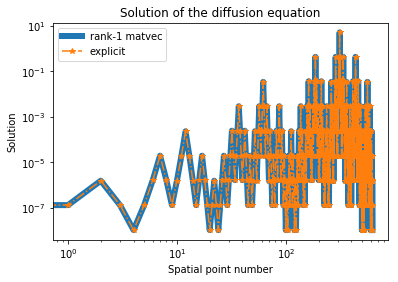

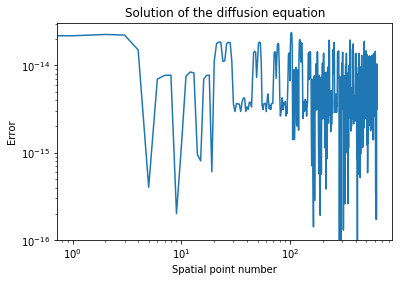

In [7]:
# Check of the result (v1 vs v2)

e = np.linalg.norm(v2 - v1) / np.linalg.norm(v2)
print('Error: %8.2e'%e)

plt.plot(np.arange(X.shape[1]), v2, linewidth=6, label='rank-1 matvec')
plt.plot(np.arange(X.shape[1]), v1, '-.', marker='*', label='explicit')
plt.title('Solution of the diffusion equation')
plt.xlabel('Spatial point number')
plt.ylabel('Solution')
plt.semilogx()
plt.semilogy()
plt.legend(loc='best')
plt.show()

e = np.abs(v2 - v1) / np.abs(v2)
plt.plot(np.arange(X.shape[1]), e)
plt.title('Solution of the diffusion equation')
plt.xlabel('Spatial point number')
plt.ylabel('Error')
plt.semilogx()
plt.semilogy()
plt.show()

In [8]:
# Check expm formula

Z1 = Z

D = np.zeros((SL.n**SL.d, SL.n**SL.d))
for i in range(SL.d):
    M = [I0] * d; M[i] = D0
    Q = M[0].copy()
    for j in range(1, SL.d): Q = np.kron(Q, M[j])
    D+= Q
Z2 = expm(D)

e = np.linalg.norm(Z2 - Z1) / np.linalg.norm(Z2)
print('Error: %8.2e'%e)

Error: 2.69e-16


<div class="head1">
    <div class="head1__name">
        Latex generation
    </div>
</div>

In [1]:
info = {
    'latex': r'''

<div class="head1">
    <div class="head1__name">
        Model problem
    </div>
    <div class="head1__note">
        One-dimensional Focker Planck equation with the zero drift
    </div>
</div>

Consider
$$
    d x = f(x, t) \, dt + S(x, t) \, d \beta,
    \quad
    d \beta \, d \beta^{\top} = Q(t) dt,
    \quad
    x(0) = x_0 \sim \rho(x, 0) = \rho_0 (x),
$$
$$
    \frac{\partial \rho(x, t)}{\partial t} =
        \sum_{i=1}^d \sum_{j=1}^d
            \frac{\partial^2}{\partial x_i \partial x_j}
            \left[ D_{ij}(x, t) \rho(x, t) \right]
        - \sum_{i=1}^d
            \frac{\partial}{\partial x_i}
            \left[ f_i(x, t) \rho(x, t) \right],
    \quad
     D(x, t) = \frac{1}{2} S(x, t) Q(t) S(x, t)^{\top},
$$
where spatial $d$-dimensional ($d \ge 1$) variable $x \in R^d$ has probability density function (PDF) $\rho(x, t)$, $\beta$ is Brownian motion of dimension $q$ ($q \ge 1$, and we assume below that $q = d$), $f(x, t) \in R^d$ is a vector-function, $S(x, t) \in R^{d \times q}$ and $Q(t) \in R^{q \times q}$ are matrix-functions and $D(x, t) \in R^{d \times d}$ is a diffusion tensor.

Let
$$
    Q(t) \equiv I,
    \,
    S(x, t) \equiv \sqrt{2 D_c} I
    \implies
    D(x, t) \equiv D_c I,
$$
and
$$
    d = 1,
    \quad
    x \in \Omega,
    \quad
    \rho(x, t) |_{\partial \Omega} \approx 0,
    \quad
    f(x, t) \equiv 0,
    \quad
    \rho_0(x) = \frac{1}{\sqrt{2 \pi s}}\exp{\left[-\frac{x^2}{2s}\right]}.
$$

It can be shown that the analytic solution is
$$
    \rho(x, t) =
        \frac
            {
                1
            }
            {
                \sqrt{2 \pi s + 4 \pi D t}
            }
        \exp{ \left[
            - \frac
                {
                    x^2
                }
                {
                    2  s + 4 D t
                }
        \right] },
$$
and the stationary solution ($t \rightarrow \infty$) is
$$
    \rho_{stat}(x) = 0.
$$

<div class="note">
    Since interpolation is not required for the case of the zero drift ($f \equiv 0$), but our solver calculates it by design, then it is expected to operate much slower than another simple solvers.
</div>

<div class="head2">
    <div class="head2__name">
        Model parameters
    </div>
    <div class="head2__note">
        <ul>
            <li>$s$ - variance of the initial condition (float, default $= 1$)</li>
            <li>$D_c$ - diffusion coefficient (float, default $= 0.5$)</li>
        </ul>
    </div>
</div>
    '''
}

from IPython.display import display, Latex, Markdown
display(Markdown(info['latex']))



<div class="head1">
    <div class="head1__name">
        Model problem
    </div>
    <div class="head1__note">
        One-dimensional Focker Planck equation with the zero drift
    </div>
</div>

Consider
$$
    d x = f(x, t) \, dt + S(x, t) \, d \beta,
    \quad
    d \beta \, d \beta^{\top} = Q(t) dt,
    \quad
    x(0) = x_0 \sim \rho(x, 0) = \rho_0 (x),
$$
$$
    \frac{\partial \rho(x, t)}{\partial t} =
        \sum_{i=1}^d \sum_{j=1}^d
            \frac{\partial^2}{\partial x_i \partial x_j}
            \left[ D_{ij}(x, t) \rho(x, t) \right]
        - \sum_{i=1}^d
            \frac{\partial}{\partial x_i}
            \left[ f_i(x, t) \rho(x, t) \right],
    \quad
     D(x, t) = \frac{1}{2} S(x, t) Q(t) S(x, t)^{\top},
$$
where spatial $d$-dimensional ($d \ge 1$) variable $x \in R^d$ has probability density function (PDF) $\rho(x, t)$, $\beta$ is Brownian motion of dimension $q$ ($q \ge 1$, and we assume below that $q = d$), $f(x, t) \in R^d$ is a vector-function, $S(x, t) \in R^{d \times q}$ and $Q(t) \in R^{q \times q}$ are matrix-functions and $D(x, t) \in R^{d \times d}$ is a diffusion tensor.

Let
$$
    Q(t) \equiv I,
    \,
    S(x, t) \equiv \sqrt{2 D_c} I
    \implies
    D(x, t) \equiv D_c I,
$$
and
$$
    d = 1,
    \quad
    x \in \Omega,
    \quad
    \rho(x, t) |_{\partial \Omega} \approx 0,
    \quad
    f(x, t) \equiv 0,
    \quad
    \rho_0(x) = \frac{1}{\sqrt{2 \pi s}}\exp{\left[-\frac{x^2}{2s}\right]}.
$$

It can be shown that the analytic solution is
$$
    \rho(x, t) =
        \frac
            {
                1
            }
            {
                \sqrt{2 \pi s + 4 \pi D t}
            }
        \exp{ \left[
            - \frac
                {
                    x^2
                }
                {
                    2  s + 4 D t
                }
        \right] },
$$
and the stationary solution ($t \rightarrow \infty$) is
$$
    \rho_{stat}(x) = 0.
$$

<div class="note">
    Since interpolation is not required for the case of the zero drift ($f \equiv 0$), but our solver calculates it by design, then it is expected to operate much slower than another simple solvers.
</div>

<div class="head2">
    <div class="head2__name">
        Model parameters
    </div>
    <div class="head2__note">
        <ul>
            <li>$s$ - variance of the initial condition (float, default $= 1$)</li>
            <li>$D_c$ - diffusion coefficient (float, default $= 0.5$)</li>
        </ul>
    </div>
</div>
    

In [3]:
from IPython.display import display, Latex
display(Latex('$\phi$'))

<IPython.core.display.Latex object>

<div class="head1">
    <div class="head1__name">
        Lyapunov solver
    </div>
</div>

Let solve a matrix equation 
$$
    A W + W A^{\top} = Q,
$$
for the unknown matrix $W$.

In [7]:
from scipy.linalg import solve_lyapunov

A = np.array([
    [1., 3., 1.],
    [5., 1., 2.],
    [0., 9., 1.],
])
Q = np.array([
    [1., 0., 1.],
    [0., 1., 0.],
    [1., 1., 1.],
])

W = solve_lyapunov(A, Q)
e = np.linalg.norm(A @ W + W @ A.T - Q)
print('Error is : %-8.2e'%e)

Error is : 1.30e-14


<div class="head1">
    <div class="head1__name">
        Matrix exponential property 2D
    </div>
</div>

Let check that
$$
    e^{A I_B + I_A B} = e^{A} \otimes e^{B}.
$$

In [9]:
Ia = np.eye(6)
Ib = np.eye(7)

A = np.random.randn(*Ia.shape)
B = np.random.randn(*Ib.shape)

E1 = expm(np.kron(A, Ib) + np.kron(Ia, B))
Ea = expm(A)
Eb = expm(B)
E2 = np.kron(Ea, Eb)
err = np.linalg.norm(E1 - E2) / np.linalg.norm(E1)

print('%-8.2e'%err)

1.19e-15


<div class="head1">
    <div class="head1__name">
        Matrix exponential property 3D
    </div>
</div>

Let check that
$$
    e^{A I_B I_C + I_A B I_C + I_A I_B C} = e^{A} \otimes e^{B} \otimes e^{C}.
$$

See [forum](https://math.stackexchange.com/questions/709114/how-to-prove-ea-oplus-b-ea-otimes-eb-where-a-and-b-are-matrices)

In [10]:
Ia = np.eye(6)
Ib = np.eye(7)
Ic = np.eye(8)

A = np.random.randn(*Ia.shape)
B = np.random.randn(*Ib.shape)
C = np.random.randn(*Ic.shape)

E1 = expm(np.kron(np.kron(A, Ib), Ic) + np.kron(Ia, np.kron(B, Ic)) + np.kron(Ia, np.kron(Ib, C)))
Ea = expm(A)
Eb = expm(B)
Ec = expm(C)
E2 = np.kron(Ea, np.kron(Eb, Ec))
err = np.linalg.norm(E1 - E2) / np.linalg.norm(E1)

print('%-8.2e'%err)

8.63e-16


<div class="head1">
    <div class="head1__name">
        Various
    </div>
</div>

In [7]:
n = [2, 3, 4]
N = np.prod(n)
A = np.arange(N*N).reshape(N, N)
i = np.array([
    [0, 1, 1, 0],
    [1, 2, 2, 0],
    [2, 3, 2, 1]
])
print(np.unravel_index(8, n, order='F'))

k = np.ravel_multi_index(i, n, order='F')
print(k)
A[np.ix_(k, k)]

(0, 1, 1)
[14 23 17  6]


array([[350, 359, 353, 342],
       [566, 575, 569, 558],
       [422, 431, 425, 414],
       [158, 167, 161, 150]])

In [12]:
t_poi = 10
t_hst = 4
t_hst = int(t_poi / t_hst) if t_hst else 0
for i in range(t_poi):
    if t_hst and (i % t_hst == 0 or i == t_poi - 1):
        print(i, t_hst)

0 2
2 2
4 2
6 2
8 2
9 2


<div class="head1">
    <div class="head1__name">
        Proof of analytic formula for solution of 1D PDF with linear drift
    </div>
</div>

Let calculate PDF $\rho(x, t)$ at time $t$ in some spatial point $x$ using transition PDF $\rho(x, t, x_0)$
$$
  \rho(x, t, x_0) =
      \frac{1}{\sqrt{2 \pi \Sigma(t)}}
      \exp{\left[
          -\frac{(x - e^{-A t} x_0)^2}{2 \Sigma(t)}
      \right]},
$$
and fixed initial condition
$$
  \rho_0(x) =
      \frac{1}{\sqrt{2 \pi s}}
      \exp{\left[
          -\frac{x^2}{2 s}
      \right]},
$$
from equation
$$
  \rho(x, t) = \int_{-\infty}^{\infty}
      \rho(x, t, x_0) \rho_0(x_0) \, d x_0.
$$

We have
$$
  \rho(x, t) = \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}\int_{-\infty}^{\infty}
      \exp{\left[
          -\frac{(x - e^{-A t} x_0)^2}{2 \Sigma(t)}  -\frac{x_0^2}{2 s}
      \right]}
      \, d x_0,
$$

$$
  \rho(x, t) = \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}\int_{-\infty}^{\infty}
      \exp{\left[
          -\frac{s (x - e^{-A t} x_0)^2 + \Sigma(t) x_0^2}{2 \Sigma(t) s}
      \right]}
      \, d x_0,
$$

$$
  \rho(x, t) =
      \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}
      \exp{\left[
          -\frac{x^2}{2 \Sigma(t)}
      \right]}
      \int_{-\infty}^{\infty}
          \exp{\left[
              \frac{- s e^{-2 A t} x_0^2 + 2 s x e^{-A t} x_0 - \Sigma(t) x_0^2}{2 \Sigma(t) s}
          \right]}
          \, d x_0,
$$

$$
  \rho(x, t) =
      \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}
      \exp{\left[
          -\frac{x^2}{2 \Sigma(t)}
      \right]}
      \int_{-\infty}^{\infty}
          \exp{\left[
              - \frac{s e^{-2 A t} + \Sigma(t)}{2 \Sigma(t) s} x_0^2
              + \frac{x e^{-A t}}{\Sigma(t)} x_0
          \right]}
          \, d x_0,
$$

Since
$$
  \int_{-\infty}^{\infty} e^{-a x^2 + b x} \, d x =
      \sqrt{\frac{\pi}{a}} e^{\frac{b^2}{4a}},
  \quad
  a > 0,
$$
we come to
$$
  \rho(x, t) =
      \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}
      \exp{\left[
          -\frac{x^2}{2 \Sigma(t)}
      \right]}
      \sqrt{\frac{2 \pi \Sigma(t) s}{s e^{-2 A t} + \Sigma(t)}}
      \exp{\left[
          \frac{2 \Sigma(t) s x^2 e^{-2 A t}}{4 \Sigma^2(t) (s e^{-2 A t} + \Sigma(t))}
      \right]},
$$

$$
  \rho(x, t) =
      \sqrt{
          \frac
              {
                  1
              }
              {
                  2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)
              }
      }
      \exp{\left[
          \frac
              {
                  s x^2 e^{-2 A t}
              }
              {
                  2 \Sigma(t) \left( s e^{-2 A t} + \Sigma(t) \right)
              }
          -
          \frac
              {
                  x^2
              }
              {
                  2 \Sigma(t)
              }
      \right]},
$$

$$
  \rho(x, t) =
      \sqrt{
          \frac
              {
                  1
              }
              {
                  2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)
              }
      }
      \exp{\left[
          \frac
              {
                  s e^{-2 A t} - s e^{-2 A t} - \Sigma(t)
              }
              {
                  2 \Sigma(t) \left( s e^{-2 A t} + \Sigma(t) \right)
              }
          x^2
      \right]},
$$

$$
  \rho(x, t) =
      \frac
          {
              1
          }
          {
              \sqrt{2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)}
          }
      \exp{\left[
          - \frac
              {
                  x^2
              }
              {
                  2 \left( \Sigma(t) + s e^{-2 A t} \right)
              }
      \right]}.
$$

<div class="end"></div>